In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import spacy
import re
import time
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from collections import Counter
from umap import UMAP

sys.path.append("../")

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


In [2]:
# NLP object creation :

nlp = spacy.load("en_core_web_lg")

# nlp._config  # Checking : tok2vec is in config by default.


In [3]:
# Reading cleaned dataset, using pickle allows type preservation (spacy doc, np array etc.)

df = pd.read_pickle(filepath_or_buffer="../data/ecommerce_cleaned.pkl")


In [4]:
df.head(n=1)


,product_name,doc_desc,lem_desc,first_category,product_specifications,image,description,category_tree
0,Elegance Polyester Multicolor Abstract Eyelet ...,"(key, elegance, polyester, multicolor, abstrac...","[key, elegance, polyester, multicolor, abstrac...",home furnishing,"{""product_specification""=>[{""key""=>""Brand"", ""v...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"[Home Furnishing, Curtains & Accessories, Curt..."


# 1 : Text classification using sparse representation (Bag of Words & TF-IDF)

- We will first try to classify the products using the sparse representation of their descriptions. We will use Bag of Words (abbreviated as BoW or CV) and TF-IDF to represent the product descriptions. We will try to predict the categories using a Multinomial Naive Bayes model.
- As this approach will generate sparse vectors (vectors containing mostly zeros), we will try to apply a dimension reduction technique, UMAP, to reduce the size of the vectors to 2 components and attempt a classification on these components.
- We will evaluate the models using the average accuracy of the predictions, sklearn's classification report, and, if necessary, a confusion matrix.

<i>Note : Since we applied tokenization, stemming and lemmentazation in notebook `nb_01` and we preserved the types by using a pickle format, it is not necessary to clean the text in this notebook.</i>

## 1.1 Feature exctraction :
&emsp;We will apply CountVectorizer & TfidfVectorizer on the whole corpus first.

In [5]:
# Stopwords have already been cleaned so we dont need to add them to the vectorizer

count_vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()


In [6]:
def get_vector(row):
    """
    returns the vector of the spacy.doc object in col doc_desc
    """
    desc_doc = row["doc_desc"]
    desc_vec = desc_doc.vector
    return desc_vec


def list_to_str(row):
    """
    Turns lem_desc, a list of tokens, into a string for CV and TF-IDF usage,
    returns string
    """
    desc_list = row["lem_desc"]
    desc_txt = " ".join(desc_list)
    return desc_txt


In [7]:
df["text_vec"] = df.apply(func=get_vector, axis=1)
df["lem_desc_txt"] = df.apply(func=list_to_str, axis=1)


In [8]:
with warnings.catch_warnings():  # Storing the results of the transformation in variables for UMAP
    warnings.simplefilter('ignore')
    count_vectorizer_transform = count_vectorizer.fit_transform(df["lem_desc_txt"])
    tf_idf_transform = tf_idf_vectorizer.fit_transform(df["lem_desc_txt"])


In [9]:
# Both should be of shape (len(df), n)

print(count_vectorizer_transform.shape)
print(tf_idf_transform.shape)


(1048, 2838)
(1048, 2838)


In [10]:
df.__len__()


1048

In [11]:
# We will use Multinomial Naive Bayes so we need to encode the categories as integers and not txt:

le = LabelEncoder()
df["enc_category"] = le.fit_transform(df["first_category"])
df[["first_category", "enc_category"]].head()


,first_category,enc_category
0,home furnishing,3
1,baby care,0
2,home furnishing,3
3,home furnishing,3
4,watches,6


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df["lem_desc_txt"],
    df["enc_category"],
    test_size=0.3,
    random_state=123
    )

# The split will be common to bow & tf-idf


# 1.2 : Predictions using Bag of words and tf_idf :

## 1.2.1 : Bag of words :

In [13]:
# applying count vectorizer previously fitted on the corpus on the data :
X_train_bow = count_vectorizer.transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)


In [14]:
# Creating and fitting model :

clf = MultinomialNB()

clf.fit(X=X_train_bow, y=y_train)


MultinomialNB()

In [15]:
y_pred_bow = clf.predict(X_test_bow)

accuracy_bow = accuracy_score(y_true=y_test, y_pred=y_pred_bow)

print(accuracy_bow)


0.9047619047619048


In [16]:
inv_bow_pred = le.inverse_transform(y_pred_bow)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [17]:
print(classification_report(y_true=inv_true, y_pred=inv_bow_pred))


                                 precision    recall  f1-score   support

                      baby care       0.86      0.71      0.77        34
beauty & personal care & health       0.92      0.94      0.93        52
     home decor & festive needs       0.96      0.89      0.92        54
                home furnishing       0.78      0.95      0.85        40
               kitchen & dining       0.98      0.92      0.95        49
                     multimedia       0.96      0.90      0.93        49
                        watches       0.86      1.00      0.92        37

                       accuracy                           0.90       315
                      macro avg       0.90      0.90      0.90       315
                   weighted avg       0.91      0.90      0.90       315



#### Observations :

- The model achieves a very high average precision of 90/91%.
- It is important to note that, due to the limited amount of data (see support), the model might benefit training on a larger set of data.

In [18]:
conf_matrix_bow = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_bow_pred))
conf_matrix_bow.columns = le.inverse_transform(conf_matrix_bow.columns)
conf_matrix_bow.index = le.inverse_transform(conf_matrix_bow.index)


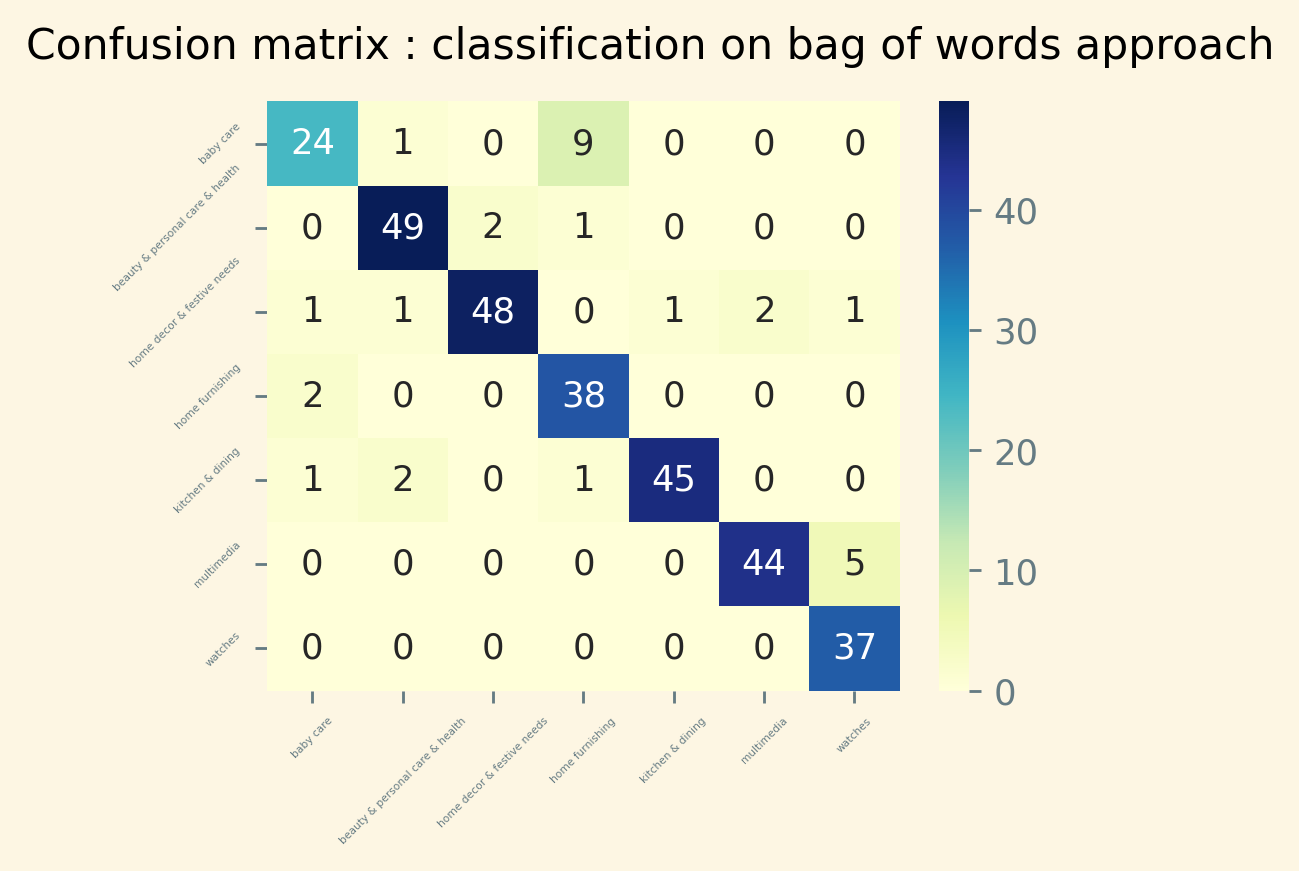

In [19]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_bow, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification on bag of words approach")
#
###

plt.show()


#### Confusion matrix :

- This matrix shows in details what could be observed in the classification report : the model's overall performances are good but might benefit from more data.
- It's also interesting to note that there were 5 items in the "multimedia" class that were misclassified as "watches". It is logical as these two categories share a lot of technical terms. This is might be the source of the errors.

## 1.2.2 : TF-IDF 


In [20]:
X_train_tfidf = tf_idf_vectorizer.transform(X_train)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)


In [21]:
clf = MultinomialNB()

clf.fit(X=X_train_tfidf, y=y_train)


MultinomialNB()

In [22]:
y_pred_tfidf = clf.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_true=y_test, y_pred=y_pred_tfidf)

print(accuracy_tfidf)


0.9079365079365079


In [23]:
inv_tfidf_pred = le.inverse_transform(y_pred_tfidf)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [24]:
print(classification_report(y_true=inv_true, y_pred=inv_tfidf_pred))


                                 precision    recall  f1-score   support

                      baby care       0.68      0.76      0.72        34
beauty & personal care & health       0.98      0.96      0.97        52
     home decor & festive needs       1.00      0.76      0.86        54
                home furnishing       0.77      0.93      0.84        40
               kitchen & dining       0.98      0.94      0.96        49
                     multimedia       0.96      1.00      0.98        49
                        watches       0.95      1.00      0.97        37

                       accuracy                           0.91       315
                      macro avg       0.90      0.91      0.90       315
                   weighted avg       0.92      0.91      0.91       315



In [25]:
conf_matrix_tfidf = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_tfidf_pred))
conf_matrix_tfidf.columns = le.inverse_transform(conf_matrix_tfidf.columns)
conf_matrix_tfidf.index = le.inverse_transform(conf_matrix_tfidf.index)


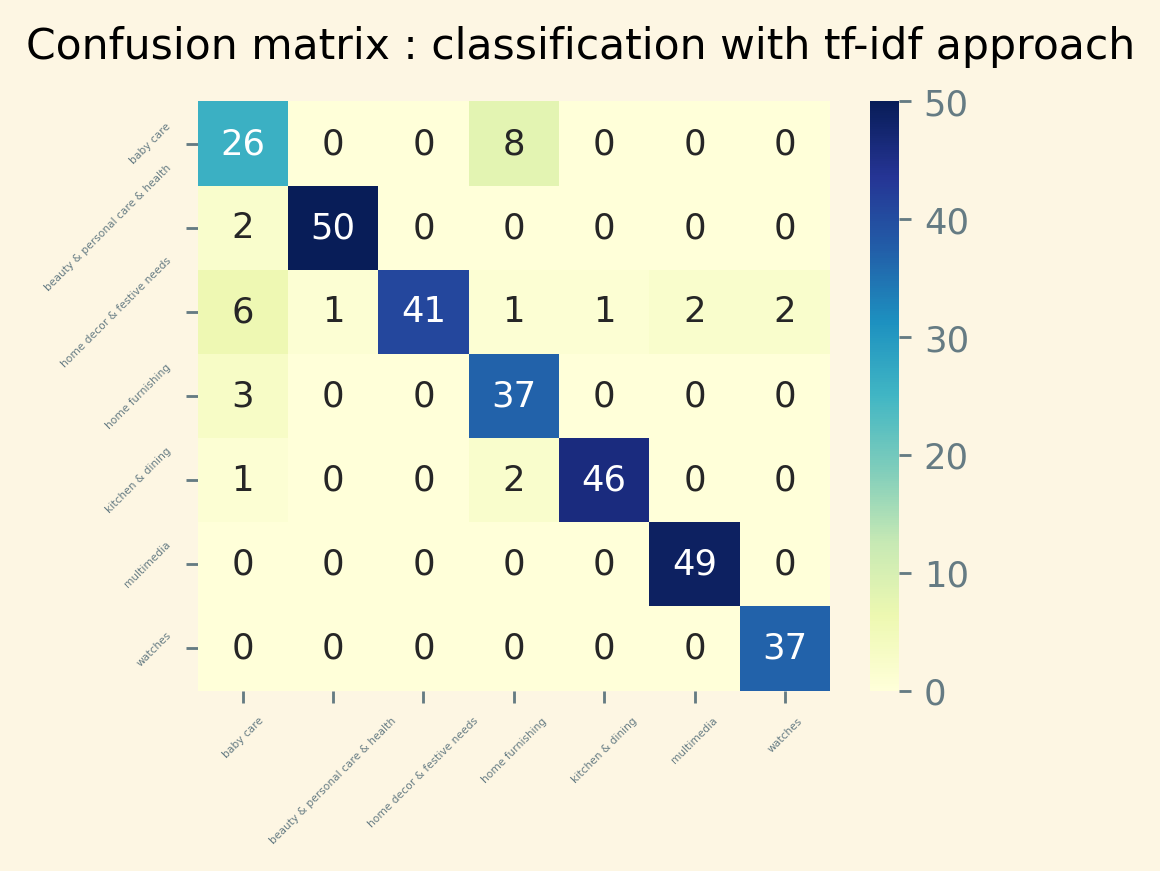

In [26]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_tfidf, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification with tf-idf approach")
#
###

plt.show()


#### Observations :
- This model performs quite well overall, with better performance in some categories than BoW but not as well in others (e.g. baby care and home furnishing).
- We could potentially improve the model by providing it with a larger training set and using hyperparameter tuning techniques like GridSearchCV to adjust the alpha of the Multinomial Naive Bayes algorithm.

## 1.3 : UMAP on vectors from count_vectorizer and tf-idf :

- This allows to reduce the dimensions to 2838 to 2 (It is worth noting that these vectors are expected to grow with a larger dataset)
- UMAP is globally faster than T-SNE for often better results


### 1.3.1 : UMAP reduction
- Using UMAP to reduce the data into two components for each approach
- Using MinMax scaler on the data to be able to use Naive Bayes (which does not work on negative values)

In [27]:
df_reduced = df.copy()  # Separating the two datasets


In [28]:
# Dimension reduction using UMAP, settings by default, 2 components

umap = UMAP(n_components=2, n_jobs=-1)

umap_cv = umap.fit_transform(count_vectorizer_transform)
umap_tfidf = umap.fit_transform(tf_idf_transform)

print(umap_cv.shape)
print(umap_tfidf.shape)


(1048, 2)
(1048, 2)


In [29]:
# saving component 0 and 1 for CountVectorizer (umap_cv) and tf-idf (umap_tfidf)
# assigning 2 cols for each method

df_reduced["umap_cv_comp_0"] = np.nan
df_reduced["umap_cv_comp_1"] = np.nan
df_reduced["umap_tfidf_comp_0"] = np.nan
df_reduced["umap_tfidf_comp_1"] = np.nan

for index in range(0, len(df)):
    df_reduced.loc[index, "umap_cv_comp_0"] = umap_cv[index][0]
    df_reduced.loc[index, "umap_cv_comp_1"] = umap_cv[index][1]
    df_reduced.loc[index, "umap_tfidf_comp_0"] = umap_tfidf[index][0]
    df_reduced.loc[index, "umap_tfidf_comp_1"] = umap_tfidf[index][1]


In [30]:
mmx = MinMaxScaler()  # Avoiding values < 0

df_reduced["umap_cv_comp_0"] = mmx.fit_transform(df_reduced["umap_cv_comp_0"].values.reshape(-1, 1))
df_reduced["umap_cv_comp_1"] = mmx.fit_transform(df_reduced["umap_cv_comp_1"].values.reshape(-1, 1))
df_reduced["umap_tfidf_comp_0"] = mmx.fit_transform(df_reduced["umap_tfidf_comp_0"].values.reshape(-1, 1))
df_reduced["umap_tfidf_comp_1"] = mmx.fit_transform(df_reduced["umap_tfidf_comp_1"].values.reshape(-1, 1))


In [31]:
# Display original text next to reduced components for cv and tf-idf :

display_cols = [
    "lem_desc_txt", "umap_cv_comp_0", "umap_cv_comp_1",
    "umap_tfidf_comp_0", "umap_tfidf_comp_1"
    ]

display(df_reduced[display_cols])


,lem_desc_txt,umap_cv_comp_0,umap_cv_comp_1,umap_tfidf_comp_0,umap_tfidf_comp_1
0,key elegance polyester multicolor abstract eye...,0.952403,0.346457,0.625687,0.650757
1,sathiyas cotton bath towel bath towel red yell...,0.847061,0.365662,0.750469,0.665325
2,key santosh royal fashion cotton print king si...,0.881904,0.369226,0.507360,0.519466
3,key jaipur print cotton floral king size doubl...,0.882072,0.370945,0.508372,0.518345
4,maserati time analog watch boy maserati time a...,0.919045,0.065174,0.935763,0.527279
...,...,...,...,...,...
1043,empower extra large self adhesive sticker pack...,0.934680,0.274346,0.716657,0.556615
1044,wallmantra large vinyl sticker sticker pack br...,0.934935,0.270568,0.716930,0.559692
1045,uberlyfe extra large pigmented polyvinyl film ...,0.933556,0.247187,0.720011,0.565011
1046,wallmantra medium vinyl sticker sticker wallma...,0.934349,0.269187,0.719018,0.565003


#### Visualisations :

##### BoW :

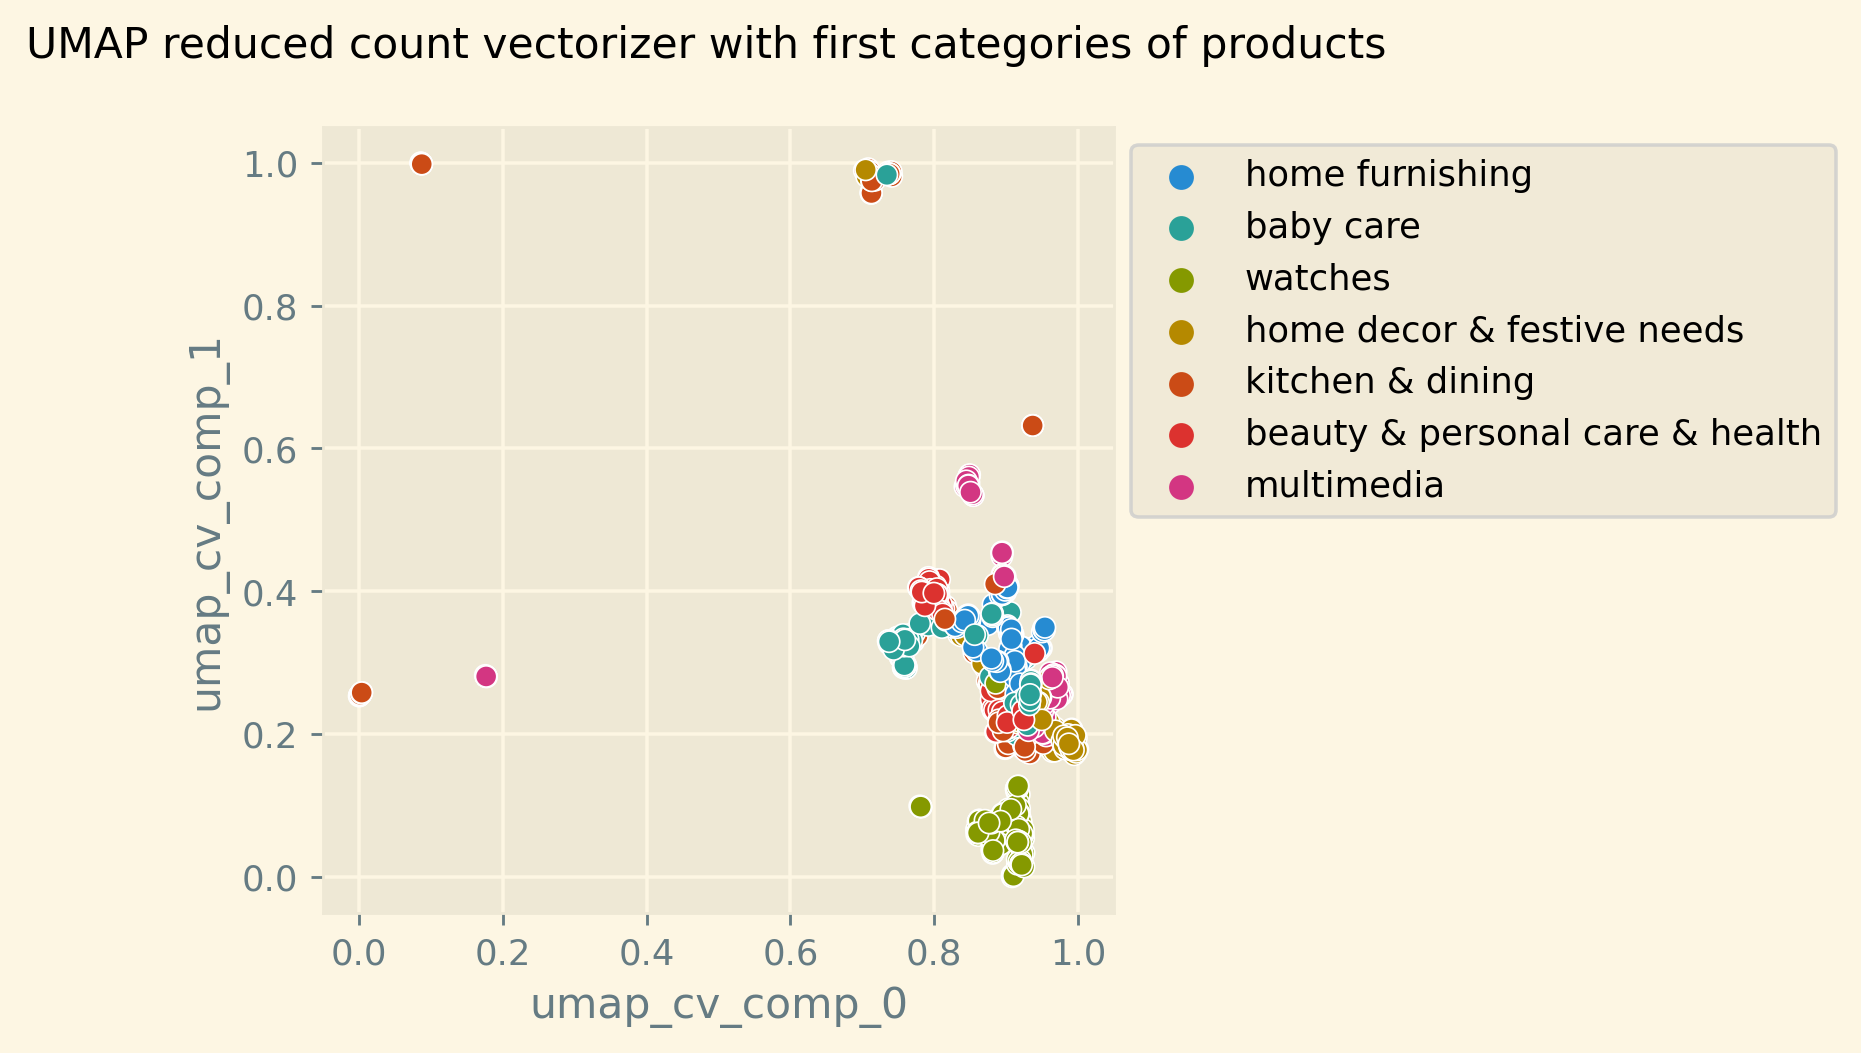

In [32]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 4),
    dpi=pc_dpi,
)

g = sns.scatterplot(data=df_reduced, x="umap_cv_comp_0", y="umap_cv_comp_1", hue="first_category", ax=ax1)

###
# Titles/Lables
sns.move_legend(
    ax1, "upper right",
    ncol=2,
    title=None,
    frameon=True,
)
plt.setp(ax1.get_legend().get_texts(), fontsize="4")
ax1.legend(bbox_to_anchor= (1,1))
fig.suptitle("UMAP reduced count vectorizer with first categories of products")
#
###

plt.show()


##### TF-IDF :

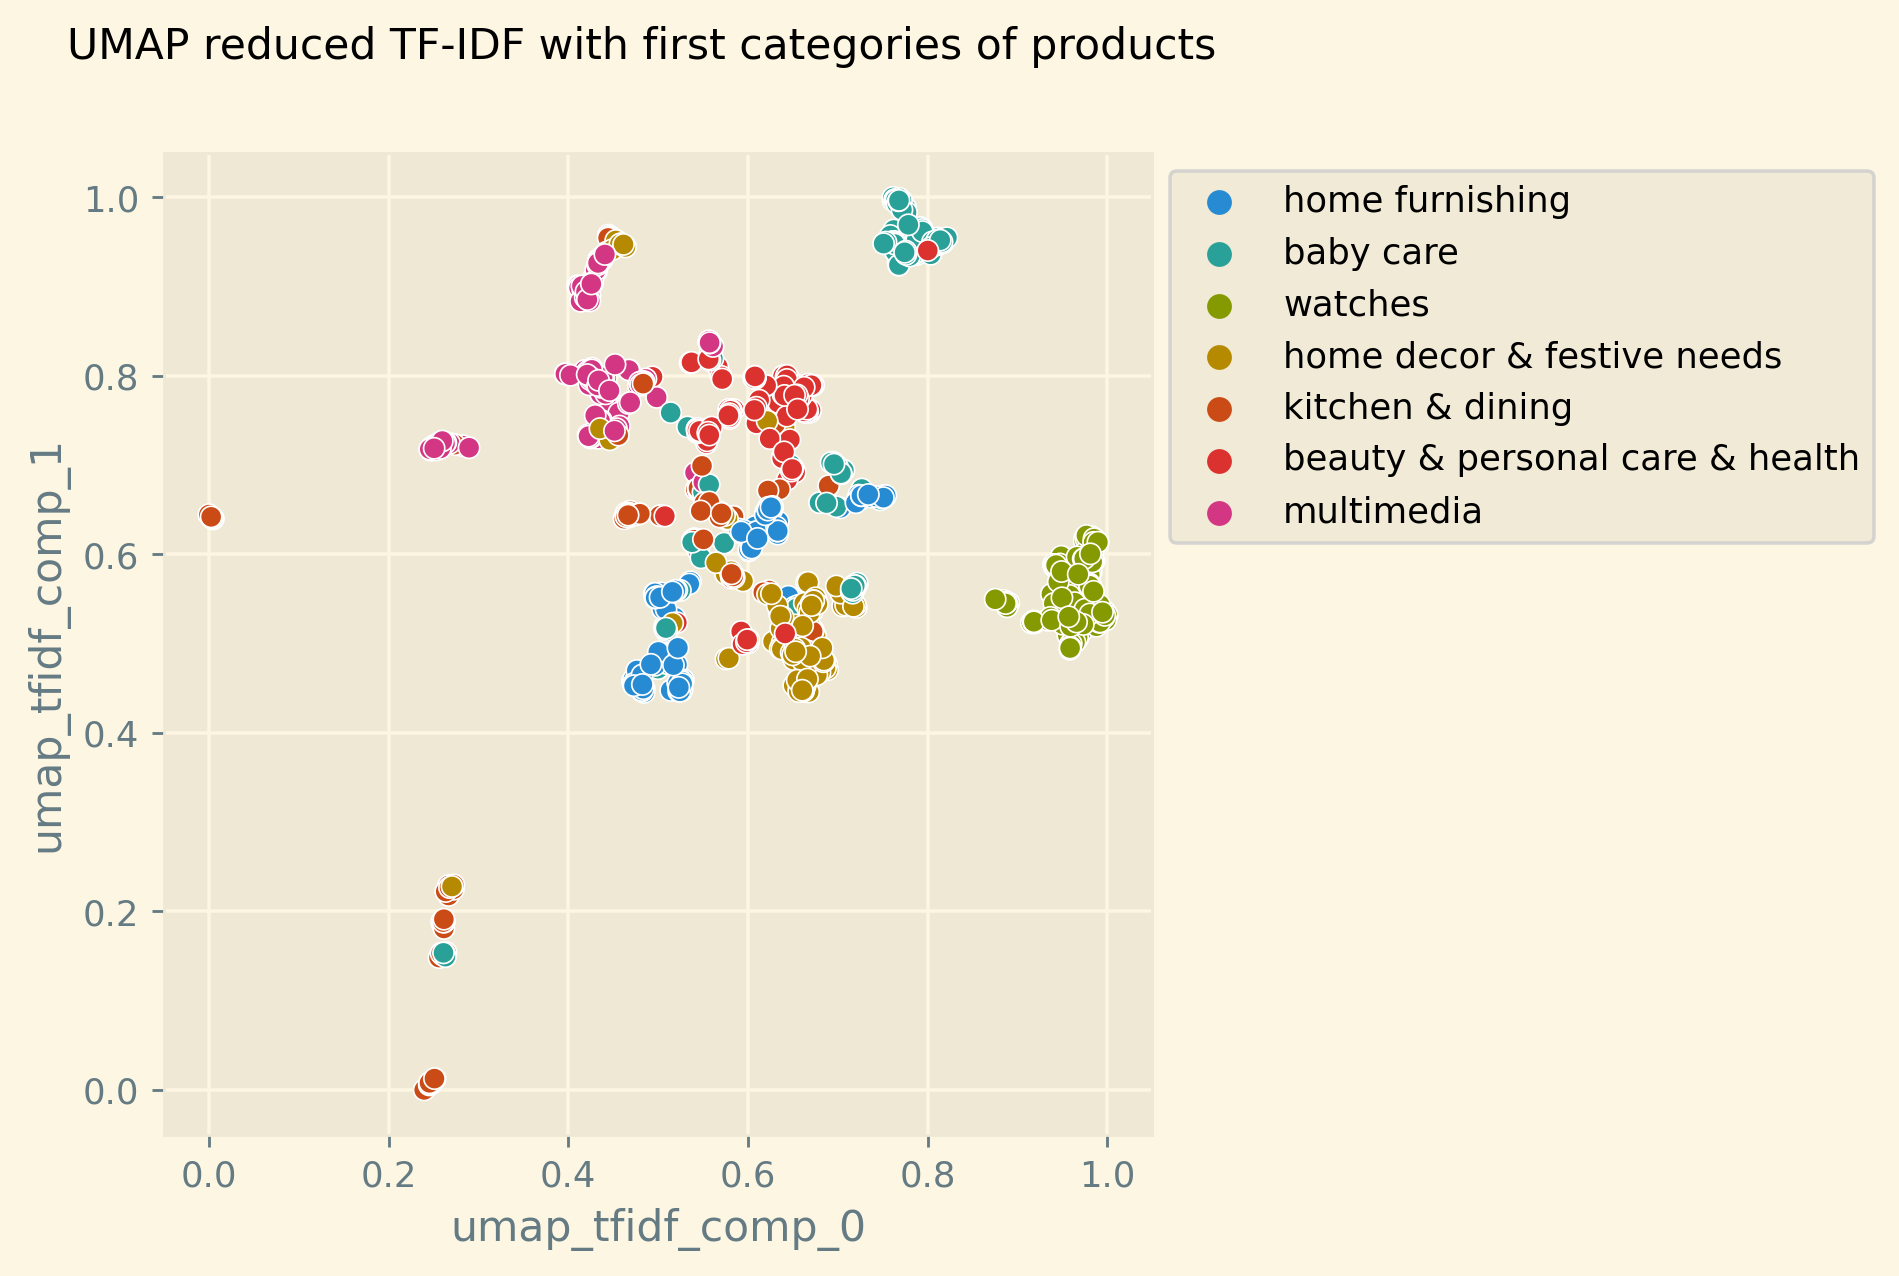

In [33]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(5, 5),
    dpi=pc_dpi,
)

g = sns.scatterplot(data=df_reduced, x="umap_tfidf_comp_0", y="umap_tfidf_comp_1", hue="first_category", ax=ax1)

###
# Titles/Lables
sns.move_legend(
    ax1, "upper right",
    ncol=2,
    title=None,
    frameon=True,
)
plt.setp(ax1.get_legend().get_texts(), fontsize="5")
ax1.legend(bbox_to_anchor=(1, 1))
fig.suptitle("UMAP reduced TF-IDF with first categories of products")
#
###

plt.show()


##### Observation :

- On both methods, the categories do not seem to exhibit major differences
- The loss of information might be too important for this approach to be relevant
- Reduction on tf-idf might be a little bit more pertinent as we see some clusters like baby care and watches isolated on the scatterplot

### 1.3.2 : Classification on Bag of Words, UMAP reduced data

In [34]:
cols_bow = ["umap_cv_comp_0", "umap_cv_comp_1", "enc_category"]

df_bow_umap = df_reduced[cols_bow]  # Creating a df for bag of words


In [35]:
X_train_bow_umap, X_test_bow_umap, y_train_bow_umap, y_test_bow_umap = train_test_split(
    df_bow_umap[["umap_cv_comp_0", "umap_cv_comp_1"]],
    df_bow_umap["enc_category"],
    test_size=0.3,
    random_state=123  # Keeping the same seed
    )


In [36]:
clf = MultinomialNB()

clf.fit(X_train_bow_umap, y_train_bow_umap)

predictions = clf.predict(X_test_bow_umap)


In [37]:
accuracy_bow_umap = accuracy_score(y_true=y_test_bow_umap, y_pred=predictions)

print(accuracy_bow_umap)


0.273015873015873


In [38]:
# Ok that seems bad, let's try a confusion matrix
conf_matrix = confusion_matrix(y_test_bow_umap, predictions)

confusion_matrix_df_bow_umap = pd.DataFrame(data=conf_matrix)


In [39]:
display(confusion_matrix_df_bow_umap)


,0,1,2,3,4,5,6
0,34,0,0,0,0,0,0
1,52,0,0,0,0,0,0
2,52,0,0,0,2,0,0
3,40,0,0,0,0,0,0
4,34,0,0,0,15,0,0
5,49,0,0,0,0,0,0
6,0,0,0,0,0,0,37


##### Observation :

- Overall, the loss of information during UMAP reduction seems to be too large for the model to be precise, with an accuracy of only 24.4%. It is likely that much of the variance was lost during the dimension reduction process, making it difficult for the classification model to be relevant on BoW.

### 1.3.2 : Classification on TF-IDF, UMAP reduced data

In [40]:
cols_tf_idf = ["umap_tfidf_comp_0", "umap_tfidf_comp_1", "enc_category"]

df_tf_idf_umap = df_reduced[cols_tf_idf]  # Creating a df for tf-idf


In [41]:
X_train_tfidf_umap, X_test_tfidf_umap, y_train_tfidf_umap, y_test_tfidf_umap = train_test_split(
    df_tf_idf_umap[["umap_tfidf_comp_0", "umap_tfidf_comp_1"]],
    df_tf_idf_umap["enc_category"],
    test_size=0.3,
    random_state=123  # same seed
    )


In [42]:
clf = MultinomialNB()

clf.fit(X_train_tfidf_umap, y_train_tfidf_umap)

predictions = clf.predict(X_test_tfidf_umap)


In [43]:
accuracy_tfidf_umap = accuracy_score(y_true=y_test_tfidf_umap, y_pred=predictions)

print(accuracy_tfidf_umap)


0.2253968253968254


In [44]:
conf_matrix = confusion_matrix(y_test_tfidf_umap, predictions)

confusion_matrix_df_umap = pd.DataFrame(data=conf_matrix)

display(confusion_matrix_df_umap)


,0,1,2,3,4,5,6
0,34,0,0,0,0,0,0
1,52,0,0,0,0,0,0
2,39,0,0,0,0,0,15
3,40,0,0,0,0,0,0
4,34,0,0,0,0,4,11
5,49,0,0,0,0,0,0
6,0,0,0,0,0,0,37


##### Observation :

- Based on the confusion matrix and the reported accuracy of 14.4%, it looks like the model is not performing well. Most of the predictions made by the model are incorrect, with a high number of false positives and false negatives.
- The dimensional reduction might be to blame for the poor performance of the model. We should consider discarding the dimensional reduction approach in order to improve the model's performance.

In [45]:
del df_bow_umap
del df_tf_idf_umap
del accuracy_bow_umap
del accuracy_tfidf_umap
# Frees a bit of memory


# 1.4 : Conclusion on BoW and TF-IDF

- Dimensional reduction is not efficient in this case, the loss of information seems to be too large.
- Both unreduced models, however, seems to perform quite well. As explained in both cases, we could benefit from a larger sample of data but, from the informations we have, both models could be used, bag of words seems to be more accurate overall but it might depend on the training.
- It is important to remember that the number of descriptions directly affects the length of the vectors generated by these approaches. As the number of descriptions increases, it is highly likely that the size of the matrices (which are linked to the size of the corpus' vocabulary) will grow, potentially negatively impacting the model's performance in terms of speed and memory usage.
<br><br><hr><br>
- Using word and sentence embedding might lead to better performances and better results.

# 2 : Word embedding :

&emsp;In the context of text classification, word embedding can be a pretty potent method over BoW and TF-IDF methods :
- Word embedding captures the semantic meaning of a word (if the model is well-trained), which, in the context of product classification, might present some advantages.
- It also presents the advantage of being a "dense" method, compared to BoW and TF-IDF which are "sparse" methods. Our corpus is quite small, but we can see that the BoW and TF-IDF vectors are very long (2838), but still manageable. If we want to upscale these methods, it would mean that these vectors would be as long as there are unique terms in the dataset, which would present a big computational and size issue. As word embedding represents a word in a vector of size (usually) 300, upscaling wouldn't be such of a problem.

<i>In a context where the dataset would be a much bigger sample, we could create our own word embedding model. However, since we have only 1048 product descriptions, creating a model based on this data might not be relevant enough, so we will use a pretrained model instead. It might be more accurate with more data or with a training dataset using only e-commerce data.</i>

## 2.1 : Selection of the model

&emsp;We have a lot of options (Google's word2vec on Google News, Stanford's GloVe on Wikipedia and Meta's Fasttext). These models are quite heavy (around 1Gb) but contain a lot of informations. Google's model is the largest but Fasttest can also be interesting to use as it is trained on Wikipedia's corpus.